In [ ]:
from mpl_toolkits import mplot3d

In [ ]:
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display
import random
import matplotlib.pyplot as plt
import math
import sys
import warnings
import numpy as np
from functools import reduce
from mpl_toolkits.mplot3d import Axes3D
import plotly.offline as offline
from plotly.graph_objs import *

Уравнение:
$$
\frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial y^2} = -2\frac{\partial u}{\partial y} - 3u.
$$

Граничные условия:
$$
u(0,y) = e^{-y}cos(y)\\
u(\pi/2, y) = 0\\
u(x, 0) = cos(x)\\
u(x, \pi/2)= 0.
$$

Аналитическое решение:
$$
U(x,y) = e^{-y}cos(x)cos(y)
$$

In [ ]:
def phi_0(y):
  return np.exp(-y) * np.cos(y)

def phi_1(y):
  return 0

def psi_0(x):
  return np.cos(x)

def psi_1(x):
  return 0


def U(x, y):
  return np.exp(-y) * np.cos(x) * np.cos(y)

In [ ]:
class Grid:
    def __init__(self, psi0 = psi_0, psi1 = psi_1, phi0 = phi_0, phi1 = phi_1,
                 lx0 = 0, lx1 = math.pi/2, ly0 = 0, ly1 = math.pi/2,
                 solver="zeidel", relax=0.1, epsilon = 0.001):
        self.psi1 = psi1
        self.psi0 = psi0
        self.phi0 = phi0
        self.phi1 = phi1
        self.lx0 = lx0
        self.ly0 = ly0
        self.lx1 = lx1
        self.ly1 = ly1
        self.eps = epsilon
        self.method = None
        if solver == "zeidel":
            self.method = self.ZeidelStep
        elif solver == "simple":
            self.method = self.SimpleEulerStep
        elif solver == "relaxation":
            self.method = lambda x, y, m: self.RelaxationStep(x, y, m, relax)
        else:
            raise ValueError("Wrong solver name")
    
    
    def RelaxationStep(self, X, Y, M, w):
        norm = 0.0
        hx2 = self.hx * self.hx
        hy2 = self.hy * self.hy
        for i in range(1, self.Ny - 1):
            for j in range(1, self.Nx - 1):
                diff = hy2 * (M[i][j-1] + M[i][j + 1])
                diff += hx2 * (M[i + 1][j] * (1 + self.hy) + M[i-1][j] * (1-self.hy))
                diff /= (2. * hy2 + 2 * hx2 - 3 * hx2 * hy2)
                diff -= M[i][j]
                diff *= w
                M[i][j] += diff
                diff = abs(diff)
                norm = diff if diff > norm else norm
        return norm
 
    def SimpleEulerStep(self, X, Y, M):
        tmp = [[0.0 for _ in range(self.Nx)] for _ in range(self.Ny)]
        norm = 0.0
        hx2 = self.hx * self.hx
        hy2 = self.hy * self.hy
        
        for i in range(1, self.Ny - 1):
            tmp[i][0] = M[i][0]
            for j in range(1, self.Nx - 1):
                tmp[i][j] = hy2 * (M[i][j - 1] + M[i][j + 1])
                tmp[i][j] += hx2 * (M[i + 1][j] * (1 + self.hy) + M[i-1][j] * (1-self.hy))
                tmp[i][j] /= (2. * hy2 + 2. * hx2 - 3. * hx2 * hy2)
                diff = abs(tmp[i][j] - M[i][j])
                norm = diff if diff > norm else norm
            tmp[i][-1] = M[i][-1]          
              
        for i in range(1, self.Ny - 1):
            M[i] = tmp[i]            
        return norm
        
        
    def ZeidelStep(self, X, Y, M):
        return self.RelaxationStep(X, Y, M, w=1)
    
    
    def Set_l0_l1(self, lx0, lx1, ly0, ly1):
        self.lx0 = lx0
        self.lx1 = lx1
        self.ly0 = ly0
        self.ly1 = ly1
        
        
    def CalculateH(self):
        self.hx = (self.lx1 - self.lx0) / (self.Nx - 1)
        self.hy = (self.ly1 - self.ly0) / (self.Ny - 1)
    
      
    @staticmethod
    def nparange(start, end, step = 1):
        now = start
        e = 0.00000000001
        while now - e <= end:
            yield now
            now += step
            
            
    def InitializeValues(self, X, Y):
        ans = [[0.0 for _ in range(self.Nx)] for _ in range(self.Ny)]
        for j in range(1, self.Nx - 1):
            coeff = (self.psi1(X[j]) - self.psi0(X[j])) / (self.ly1 - self.ly0)
            addition = self.psi0(X[j])
            for i in range(self.Ny):
                ans[i][j] = coeff*(Y[i] - self.ly0) + addition
        for i in range(self.Ny):
            ans[i][0] = self.phi0(Y[i])
            ans[i][-1] = self.phi1(Y[i])          
        return ans

    
    def __call__(self, Nx=10, Ny=10):
        self.Nx, self.Ny = Nx, Ny
        self.CalculateH()
        x = list(self.nparange(self.lx0, self.lx1, self.hx))
        y = list(self.nparange(self.ly0, self.ly1, self.hy))
        ans = self.InitializeValues(x, y)        
        self.itters = 0        
        while(self.method(x, y, ans) >= self.eps):
            self.itters += 1        
        return x, y, ans

In [ ]:
def Error(X, Y, Z, U):
    ans = 0.0
    for i in range(len(Y)):
        for j in range(len(X)):
            tmp = abs(Z[i][j] -  U(X[j], Y[i]))
            ans = tmp if tmp > ans else ans
    return ans

In [ ]:
def error_on_x( method, U, h_0, h_l , T,  name=None):
    steps = []
    e = []
    _, ax = plt.subplots(1,1,figsize=(12,6))
    for N in range(h_0, h_l):
        x, y, z = method(N, T)
        steps.append(N)
        err = Error(x, y, z, U)
        e.append(err)
    e.reverse()
    ax.plot(steps, e, c='red')
    info = name + "\nЗависимость ошибки от мелкости разбиения по x"
    ax.set_title(info)
    ax.set_xlabel("Число разбиений")
    ax.set_ylabel("Ошибка")

In [ ]:
def error_on_y( method, U, t_0, t_l, H, name=None):
    steps = []
    e = []
    _, ax = plt.subplots(1,1,figsize=(12,6))
    for N in range(t_0, t_l):
        x, y, z = method(H, N)
        steps.append(N)
        err = Error(x, y, z, U)
        e.append(err)
    e.reverse()
    ax.plot(steps, e, c='red')
    info = name + "\nЗависимость ошибки от мелкости разбиения по y"
    ax.set_title(info)
    ax.set_xlabel("Число разбиений")
    ax.set_ylabel("Ошибка")

In [ ]:
def depend_on_y(X, Y, Z, name=None, method=None):
    t = np.linspace(0.1, len(Y), num=5, endpoint=False, dtype=int)
    _, ax = plt.subplots(1,1,figsize=(12,6))
    for i in t:
        ax.plot(X, Z[i])
    legends = ["y=" + str(Y[i]) for i in t]
    ax.legend(legends)
    #info = name + "\nh = " + str(round(method.h, 3))  + ", sigma = " + str(round(method.sigma, 3))
    #ax.set_title(info)
    ax.set_xlabel("x")
    ax.set_ylabel("U(x,t)")

In [ ]:
simple = Grid(epsilon=0.0001, solver="simple")
X1, Y1, Z1 = simple(50, 50)
print("Количество итераций метода простых итераций = {}".format(simple.itters))

Количество итераций метода простых итераций = 634


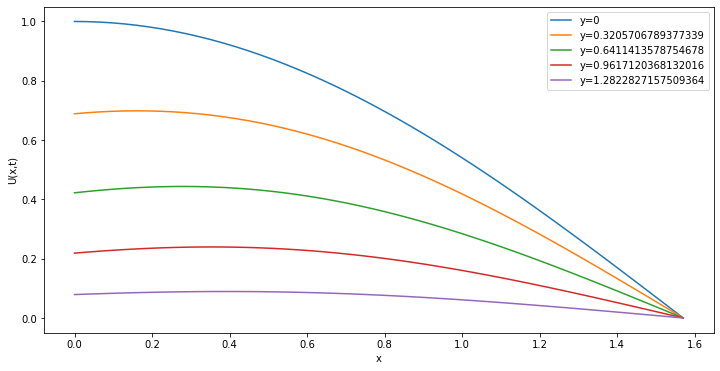

In [ ]:
depend_on_y(X1,Y1,Z1)

Text(0.5, 0.92, 'Метод простых итераций')

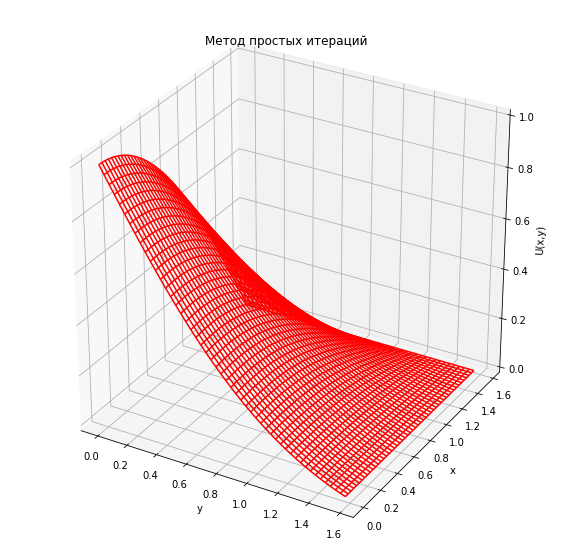

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
X1g, Y1g = np.meshgrid(X1,Y1)
Z1 = np.array(Z1)
ax.plot_wireframe(Y1g,X1g,Z1, color = 'r')
ax.set_xlabel("y")
ax.set_ylabel("x")
ax.set_zlabel("U(x,y)")
ax.set_title("Метод простых итераций")

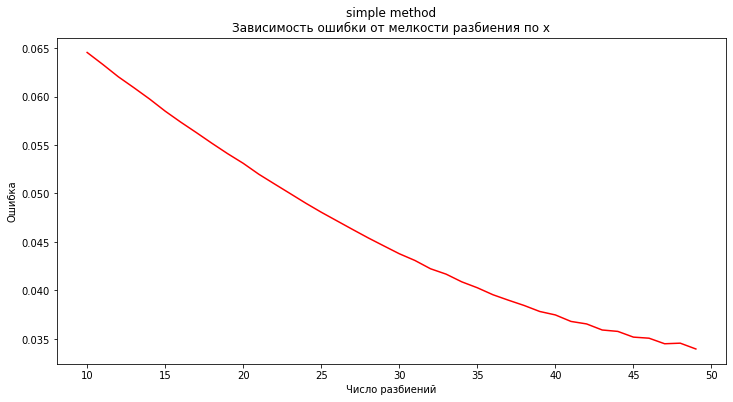

In [ ]:
error_on_x(simple, U, 10, 50, 50, "simple method")

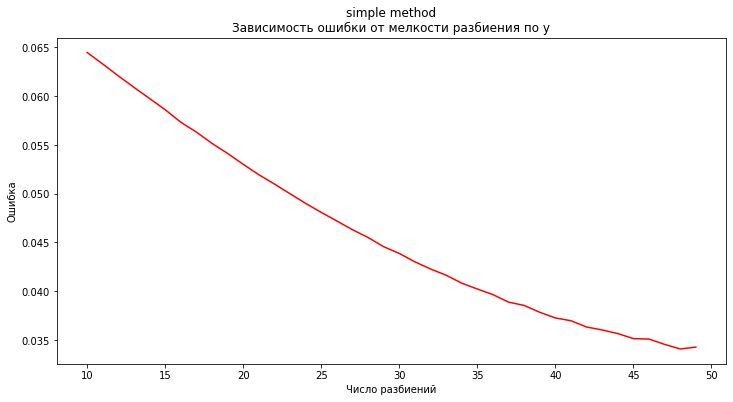

In [ ]:
error_on_y(simple, U, 10, 50, 50, "simple method")

In [ ]:
seidel = Grid(epsilon=0.0001)
X2, Y2, Z2 = seidel(50, 50)
print("Количество итераций метода Зейделя = {}".format(seidel.itters))

Количество итераций метода Зейделя = 550


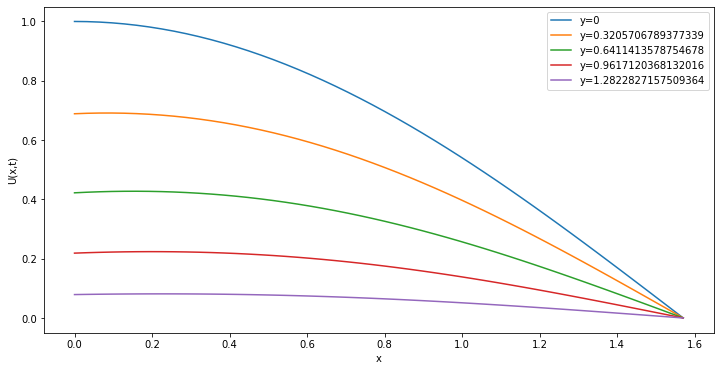

In [ ]:
depend_on_y(X2,Y2,Z2)

Text(0.5, 0.92, 'Метод зейделя')

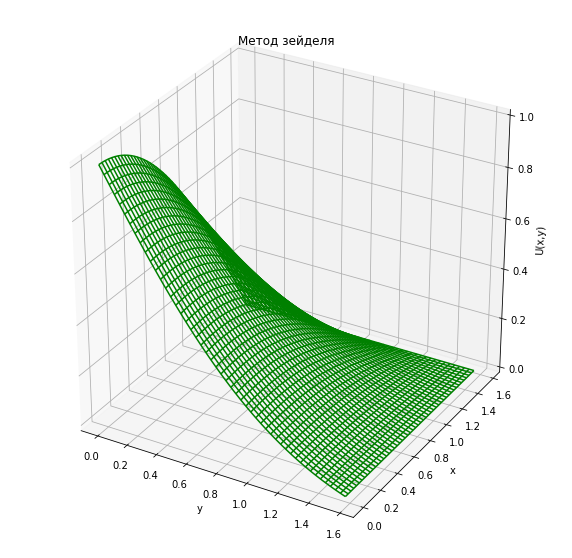

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
X2g, Y2g = np.meshgrid(X2,Y2)
Z1 = np.array(Z2)
ax.plot_wireframe(Y2g,X2g,Z2, color = 'g')
ax.set_xlabel("y")
ax.set_ylabel("x")
ax.set_zlabel("U(x,y)")
ax.set_title("Метод зейделя")

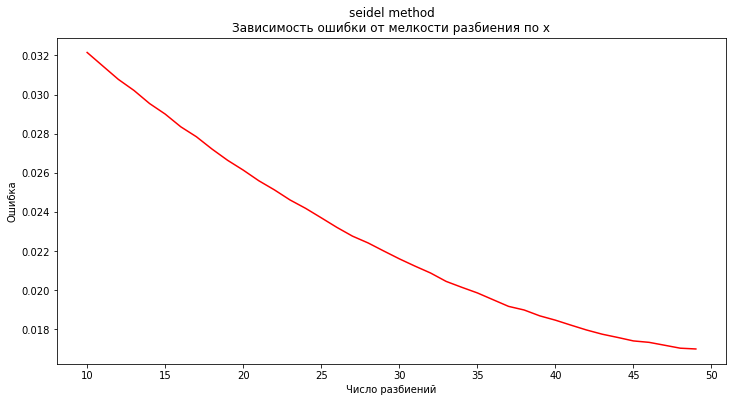

In [ ]:
error_on_x(seidel, U, 10, 50, 50, "seidel method")

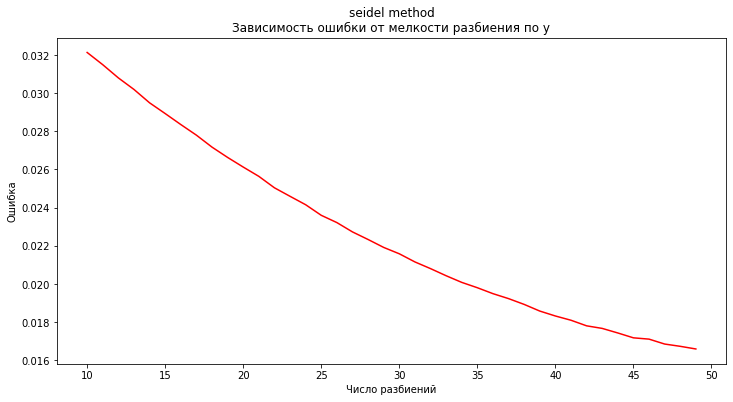

In [ ]:
error_on_y(seidel, U, 10, 50, 50, "seidel method")

In [ ]:
relax = Grid(epsilon=0.0001, solver="relaxation", relax=1.5)
X3, Y3, Z3 = relax(50, 50)
print("Количество итераций метода релаксаций = {}".format(relax.itters))

Количество итераций метода релаксаций = 305


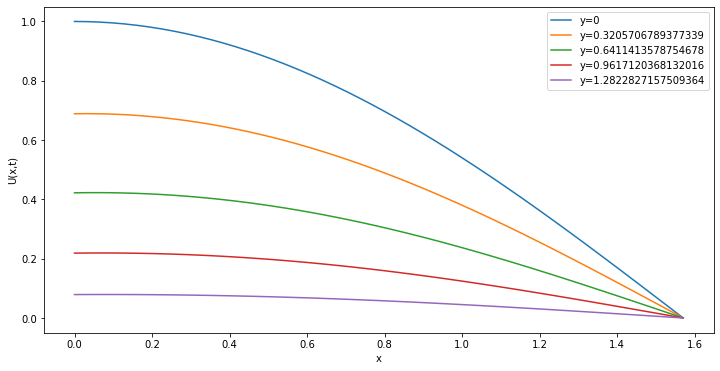

In [ ]:
depend_on_y(X3,Y3,Z3)

Text(0.5, 0.92, 'Метод релаксации')

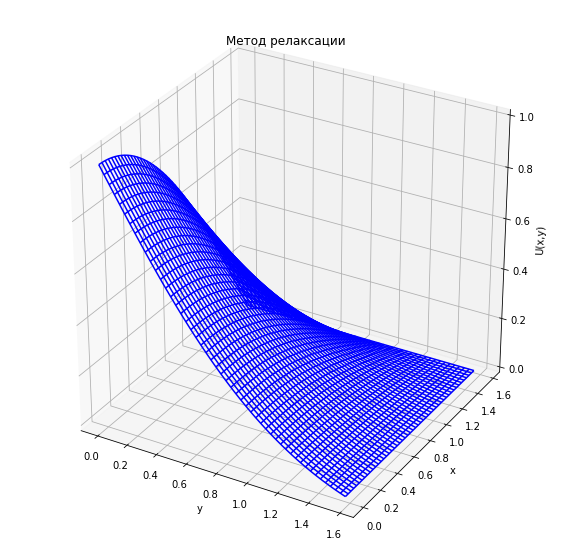

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
X3g, Y3g = np.meshgrid(X3, Y3)
Z3 = np.array(Z3)
ax.plot_wireframe(Y3g,X3g,Z3, color = 'b')
ax.set_xlabel("y")
ax.set_ylabel("x")
ax.set_zlabel("U(x,y)")
ax.set_title("Метод релаксации")

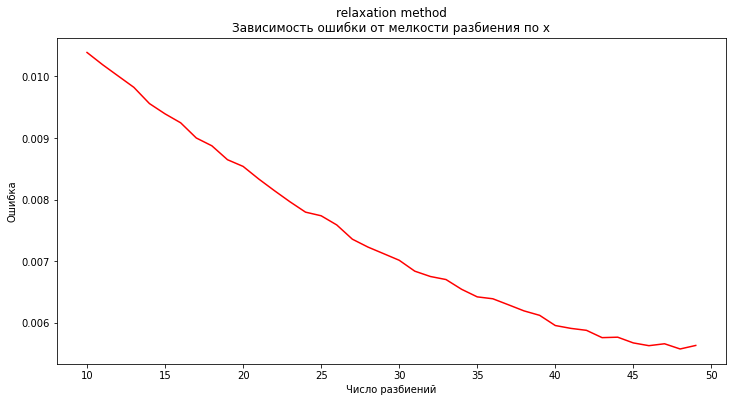

In [ ]:
error_on_x(relax, U, 10, 50, 50, "relaxation method")

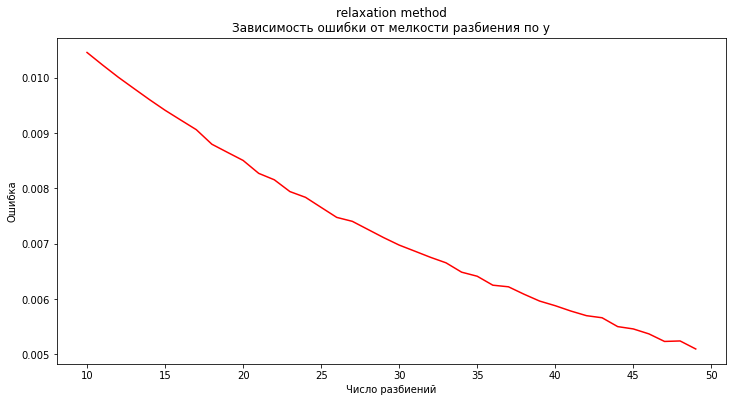

In [ ]:
error_on_y(relax, U, 10, 50, 50, "relaxation method")